In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from utils import generate_inputs_test as gen, adam, initialize_adam
from utils import load_dataset 

In [3]:
def params_init(nx : int, seed : int = None, random_init : bool=False):

    # generate the sample random numbers 
    if seed : np.random.seed(seed=seed)
    # initializing params as python dictionary 
    params = {}

    # creating weight and bias for one neuron
    # as we said to the README file we just have one neuron (binary classification)
    ny = 1
    for i in range(ny):
        if random_init : 
            params[f'W{i+1}'] = np.random.randn(1, nx) * 0.01
        else:
            params[f'W{i+1}'] = np.zeros((1, nx))
        params[f'b{i+1}'] = np.zeros((1, 1))

    # returning the output as a dictionary
    return params 

In [4]:
def sigmoid(x : np.ndarray):
    # computing sigmoid function for a given value x 

    sig = 1. / (1 + np.exp(-x))

    return sig 

In [5]:
def forward_propagation(X : np.ndarray, params : dict):
    # layers 
    layers = len(list(params.keys())) // 2

    # linearity & prediction 
    # Z = W.dot(X) + b
    # A = sigmoid(Z)
    Z, A = {},{}
  
    for layer in range(layers):
        # linearity
        Z[layer+1] = params[f"W{layer+1}"].dot(X) + params[f'b{layer+1}']
        # prediction
        A[layer+1] = sigmoid(x=Z[layer+1])
    
    cache = {"Z" : Z, "A" : A}

    return A[layers], cache 

In [6]:
def cost_function(A : np.ndarray, Y: np.ndarray):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    * A -- The activation output of the last layer, of shape (sy, m)
    * Y -- "true" labels vector of shape (ny, m)

    in the case of binary classification ny = 1
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    A.shape = 
    Y.shape = (1, ny)
    """
    
    m       = Y.shape[1] 
    # two method to compute cost function 
    #cost    = -(1./m) * (np.dot(Y, np.log(A).T) + np.dot(1-Y, np.log(1-A).T))
    cost    = -(1. / m) * ( ( Y * np.log(A) ) + (1 - Y) * np.log(1 - A) ).sum(axis=1)
    
    # np.squeeze(cost) --> np.squeeze([[1]]) = 1.0
    cost    = float(np.squeeze(cost))   
                                    
    return cost

In [7]:
def backward_propagation(
        params  : dict, 
        cache   : dict, 
        X       : np.ndarray, 
        Y       : np.ndarray
        ):
    
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    params -- python dictionary containing our parameters 
    cache -- a dictionary containing A, and Z (activations and linear calculations).
    X -- input data of shape (nx, number of examples)
    Y -- "true" labels vector of shape (ny, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    # nomber of sample 
    m       = X.shape[1]
    # intialize gradient 
    grads   = {}
    # restoring activation & linearity from cache 
    A, Z    = cache['A'], cache['Z']  
    # computing the number of layers 
    layers  = len(list(params.keys())) // 2

    # updating gradient 
    # dZ = A[layers] - Y
    grads[f'dZ{layers}'] = A[layers] - Y
    # dW = dZ.dot(X.T)
    grads[f'dW{layers}'] = grads[f'dZ{layers}'].dot(X.T) * (1. / m)
    # db = 1
    grads[f'db{layers}'] = np.sum(grads[f'dZ{layers}'], axis=1, keepdims=True) / m

    return grads 

In [8]:
def clip(gradients : dict = {}, maxValue : float = 10):

    """
    clip funsion is ued to solve the issue of exploding gradient.
    by fixing the border limits the gradient cannot exceded we can solve that problem 

    * firstly we start by defining the border limits [-L, L]
    if the value of gardient id outside of this range we put it inside like this 
        - if grad > L  ---> grad = L
        - if grad < -L ---> grad = L
        - else grad = pass

    * so to make it possible we need the value of L in this case L = maxValues argument

    """
    
    for key, value in gradients.items():
        np.clip(a=value, a_min=-maxValue, a_max=maxValue, out=value)

        gradients[key] = value

    return gradients


In [9]:
def prediction(params, X, as_bool : bool = True):
    # layers 
    layers = len(list(params.keys())) // 2

  
    Z = params[f"W{layers}"].dot(X) + params[f'b{layers}']
    # prediction
    y_pred = sigmoid(x=Z)
    m = y_pred.shape[1]

    prediction = np.zeros((1, m))
    for j in range(m):
        if y_pred[0, j] > 0.5 : prediction[0, j] = 1
        else: prediction[0, j] = 0
    
    return prediction

def scoring(y_true : np.ndarray, y_pred : np.ndarray):

    return (y_pred == y_true).sum() / y_pred.shape[1]

In [10]:
def updating_params(grads : dict, params : dict, learning_rate : float = 0.01):

    # number of layers
    layers = len( list(params.keys()) ) // 2

    # updating the weight and bias using the gradient (stochastic gradient descend)
    for layer in range(layers):
        params[f'W{layer+1}'] = params[f'W{layer+1}'] - learning_rate * grads[f'dW{layer+1}']
        params[f'b{layer+1}'] = params[f'b{layer+1}'] - learning_rate * grads[f'db{layer+1}']

    # returning the updating weight and bias 

    return params

In [11]:
def LogisticRegression(
        X : np.ndarray,
        Y : np.ndarray,
        validation_data     : tuple = None,
        maxValue            : float = None,
        early_stoping       : int   = 10000,
        learning_rate       : float = 1e-3,
        print_val           : bool  = True,
        epsilon             : float = 1e-8,
        verbose             : bool  = True,
        step                : int   = 100, 
        seed                : int   = None,
        optimizer           : str   = "sgd",
        beta1               : float = 0.8,
        beta2               : float = 0.85,
        t                   : float = 2.5,
        random_init         : bool  = False
       ):

    nx      = X.shape[0]
    params  = params_init(nx=nx, seed=seed, random_init=random_init)

    history = {"cost" : [], "accuracy" : [], 'val_accuracy' : []}
    
    i = 0
  
    while True:
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A_last, cache = forward_propagation(X=X, params=params)
        
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        # cost = ...
        cost = cost_function(A=A_last, Y=Y)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(params=params, cache=cache, X=X, Y=Y)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        if maxValue : grads = clip(gradients=grads, maxValue=maxValue)

        if optimizer == "sgd" : params = updating_params(params=params, grads=grads, learning_rate=learning_rate)
        else:
            v, s = initialize_adam(params=params) 
            params,v, s = adam(params=params, grads=grads, v=v, s=s, t=t, beta1=beta1, beta2=beta2, learning_rate=learning_rate, epsilon=epsilon)
           
        if validation_data:
            x_test, y_test  = validation_data
            y_pred_test     = prediction(params=params.copy(), X=x_test, as_bool=True)

        y_pred      = prediction(params=params.copy(), X=X, as_bool=True)
        accuracy    = scoring(y_true=Y, y_pred=y_pred)
        
        # Print the cost every 1000 iterations
        if verbose and i % step == 0:        
            if i == 0 : pass 
            else:
                if history['cost']:
                    if np.abs(history['cost'][-1] - cost) < epsilon: 
                        print("loop break due np.abs( cost[i] - cost[i-1]) < epsilon")
                        break
                    else: pass
                else: pass 

            if validation_data: 
                val_accuracy    = scoring(y_true=y_test, y_pred=y_pred_test)
                history['val_accuracy'].append(val_accuracy)

            history['cost'].append(cost)
            history['accuracy'].append(accuracy)

            if print_val : 
                if validation_data : print ("epoch: %i cost: %f scoring: %f val_accuracy: %f" %(i, cost, accuracy, val_accuracy))
                else:  print ("epoch: %i cost: %f scoring: %f" %(i, cost, accuracy))
        else: pass 
        
        i += 1 
        if early_stoping:
            if i >= early_stoping: 
                print("loop break due to early stoping parameter")
                break 
            else: pass 
        else: pass
        
    return history, params

In [12]:
X_train, y_train, X_test, y_test, classes = load_dataset()

In [13]:
shape_1 = X_train.shape
shape_2 = X_test.shape 
shape_1, shape_2

((209, 64, 64, 3), (50, 64, 64, 3))

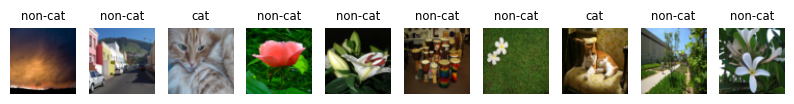

In [14]:
n_imgaes = 10
fig, axes = plt.subplots(1, n_imgaes, figsize=(n_imgaes, 1))

for i in range(n_imgaes):
    axes[i].axis("off")
    axes[i].imshow(X_train[i])
    axes[i].set_title(f"{classes[y_train[:, i][0]].decode()}", fontsize="small")
plt.show()


In [15]:
X_train = X_train.reshape((-1, shape_1[0])) / 255.
X_test  = X_test.reshape((-1, shape_2[0])) / 255.
X_train.shape, X_test.shape

((12288, 209), (12288, 50))

In [27]:
history, params = LogisticRegression(X=X_train, Y=y_train, maxValue=None, print_val=True, learning_rate=0.005, beta1=0.9, beta2=0.99,
                step=10, early_stoping=1000, epsilon=1e-6, optimizer='adam', t=2, validation_data=(X_test, y_test), random_init=None)

epoch: 0 cost: 0.693147 scoring: 0.655502 val_accuracy: 0.340000
epoch: 10 cost: 0.880111 scoring: 0.655502 val_accuracy: 0.340000
epoch: 20 cost: 0.863583 scoring: 0.655502 val_accuracy: 0.340000
loop break due np.abs( cost[i] - cost[i-1]) < epsilon


In [17]:
df = pd.DataFrame(history)
display(df.head())

,cost,accuracy,val_accuracy
0,0.693147,0.655502,0.34
1,1.107021,0.655502,0.34
2,0.780825,0.655502,0.34
3,1.042908,0.655502,0.34
4,0.809259,0.655502,0.34


<Axes: >

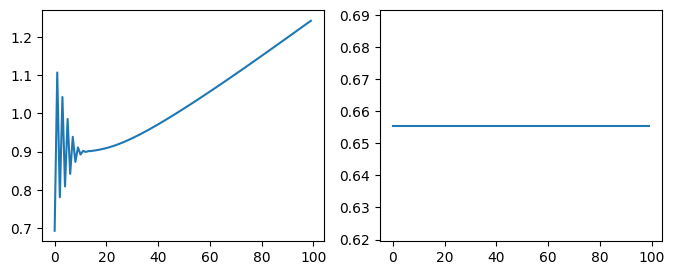

In [18]:
f, axes = plt.subplots(1, 2, figsize=(8, 3))
df['cost'].plot(ax=axes[0])
df['accuracy'].plot(ax=axes[1])

In [19]:
y_pred_train = prediction(params=params, X=X_train)
y_pred_test = prediction(params=params, X=X_test)

In [20]:
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns 
from skimage.transform import resize

In [21]:
Cm = cm(y_pred=y_pred_test.reshape((-1,)), y_true=y_test.reshape((-1,)))
y_pred_test

print(f"scoring : {scoring(y_test, y_pred_test)}")

scoring : 0.66


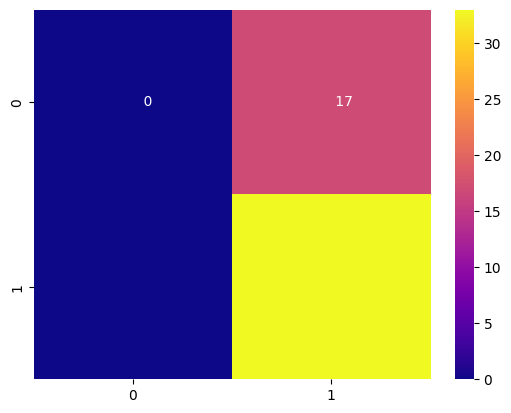

In [22]:
sns.heatmap(Cm, annot=True, fmt="8d", cmap="plasma")
plt.show()

In [23]:
img_path = "https://th.bing.com/th/id/OIP.ynvWUamlRIDE8HVYIL2e3gHaHa?pid=ImgDet&rs=1"

In [24]:
from utils import url_img_read

img = url_img_read(url=img_path,show_img=True)

An error occurred: HTTPSConnectionPool(host='th.bing.com', port=443): Max retries exceeded with url: /th/id/OIP.ynvWUamlRIDE8HVYIL2e3gHaHa?pid=ImgDet&rs=1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000224812174D0>: Failed to resolve 'th.bing.com' ([Errno 11001] getaddrinfo failed)"))
response time : 11.1154s


In [25]:
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
img_resize  = resize(img, output_shape=(64, 64))

In [ ]:
img = img_resize.reshape((-1, 1))
img.shape

(12288, 1)

In [ ]:
y_pred = prediction(params=params, X=img)

C:\Users\amib\AppData\Local\Temp\ipykernel_48324\492405570.py:4: RuntimeWarning: overflow encountered in exp
  sig = 1. / (1 + np.exp(-x))


In [ ]:
classes[np.squeeze(y_pred).astype('int')].decode()

'non-cat'